In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
_HYPER_KVASIR = 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images'
## ubuntu dir
# _HYPER_KVASIR = '/home/nguyentai/working/data/hyper_kvasir/labeled-images-resize'
# _HYPER_KVASIR_LABELED_DEFORM = 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images_deform'

In [32]:
df_unanno = pd.read_csv('../resource/hyper_kvasir/full_unlabeled.csv')
# df_unanno.head()

In [33]:
df_anno = pd.read_csv('../resource/hyper_kvasir/full_labeled_anno.csv')
# df_anno.head()

In [34]:
full_categories = pd.read_csv('../resource/hyper_kvasir/categories.csv')
pathological_categories = pd.read_csv('../resource/hyper_kvasir/pathological_categories.csv')
pathological_categories
# categories

,target,pathologies,samples,old_target
0,0,polyps,1028,4
1,1,ulcerative-colitis-grade-2,443,6
2,2,esophagitis-a,403,9
3,3,esophagitis-b-d,260,11
4,4,ulcerative-colitis-grade-1,201,3
5,5,ulcerative-colitis-grade-3,133,1


In [40]:
df_patho_12 = pd.read_csv('../resource/hyper_kvasir/df_pathologies.csv')
df_patho_12.head()

,index,image,target,is_valid
0,180,lower-gi-tract/pathological-findings/ulcerativ...,6,False
1,2458,lower-gi-tract/pathological-findings/polyps/93...,4,False
2,2969,lower-gi-tract/pathological-findings/ulcerativ...,1,False
3,5388,lower-gi-tract/pathological-findings/polyps/be...,4,False
4,6219,lower-gi-tract/pathological-findings/polyps/c3...,4,False


In [8]:
# list_paths = []
# for c in categories['findings']:
#     path = df_anno[df_anno['Finding']==c]['Image'].iloc[0]
#     path = '/'.join(path.split('/')[:-1])
#     list_paths.append(path)

In [9]:
# categories['path'] = list_paths
# categories.to_csv('../resource/hyper_kvasir/categories.csv', index=False, header=True)

## Mock k-fold

In [11]:
df_kfold = pd.read_csv('../resource/hyper_kvasir/df_full_kfold.csv')

In [29]:
df_train = df_kfold[df_kfold['is_valid']==False]
df_train.head()

,file-name,class-name,split-index,image,target,is_valid
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False


In [72]:
df_valid = pd.DataFrame([])
df_valid['image'] = list(df_kfold[df_kfold['is_valid']==True]['image'])
df_valid['target'] = list(df_kfold[df_kfold['is_valid']==True]['target'])
df_valid['is_valid'] = True
df_valid['is_labeled'] = True

In [75]:
# df_valid

In [13]:
x_train = list(df_train['image'])
y_train = list(df_train['target'])

In [83]:
check = 0
while check != 23:
    x_train_unlab, x_train_lab, y_train_unlab, y_train_lab  = train_test_split(x_train, 
                                                                              y_train, 
                                                                              test_size=0.2)
                                                                              # random_state=0)
    check = len(set(y_train_lab))
    df_train_lab = pd.DataFrame([])
    df_train_lab['image'] = x_train_lab
    df_train_lab['target'] = y_train_lab
    df_train_lab['is_valid'] = False
    df_train_lab['is_labeled'] = True

    df_train_unlab = pd.DataFrame([])
    df_train_unlab['image'] = x_train_unlab
    df_train_unlab['target'] = y_train_unlab
    df_train_unlab['is_valid'] = False
    df_train_unlab['is_labeled'] = False

    df_full_mock = pd.concat([df_train_lab, df_train_unlab, df_valid], axis=0)

In [84]:
df_full_mock.to_csv('../resource/hyper_kvasir/df_split_mock_2_8.csv', index=False, header = True)

## Read k-fold split

In [8]:
df_kfold = pd.read_csv('../resource/hyper_kvasir/2_fold_split.csv', sep = ';')
df_kfold.head()

,file-name,class-name,split-index
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0


In [52]:
dict_correct_cat_name = {'oesophagitis-b-d': 'esophagitis-b-d',
                         'short-segment-barretts': 'barretts-short-segment',
                         'oesophagitis-a': 'esophagitis-a',
                         'normal-pylorus': 'pylorus',
                         'hemorroids': 'hemorrhoids',
                         'normal-cecum': 'cecum',
                         'polyp': 'polyps',
                         'normal-z-line': 'z-line'}

In [58]:
list_img_path = []
list_targets = []
for i in range(len(df_kfold)):
    cls_name = df_kfold['class-name'].iloc[i]
    if cls_name in dict_correct_cat_name.keys():
        df_kfold['class-name'].iloc[i] = dict_correct_cat_name[cls_name]
        
    cls_name = df_kfold['class-name'].iloc[i]
    dir_path = categories[categories['findings']==cls_name]['path'].iloc[0]
    img_path = os.path.join(dir_path, df_kfold['file-name'].iloc[i]).replace('\\','/')
    list_img_path.append(img_path)
    target = categories[categories['findings']==cls_name]['target'].iloc[0]
    list_targets.append(target)

In [54]:
# list_cate_kfold = list(set(list(df_kfold['class-name'])))
# for item in list_cate_kfold:
#     if not item in list(categories['findings']):
#         print(item)

In [59]:
df_kfold['image'] = list_img_path
df_kfold['target'] = list_targets
df_train = df_kfold[df_kfold['split-index']==0]
df_train['is_valid'] = False
df_valid = df_kfold[df_kfold['split-index']==1]
df_valid['is_valid'] = True

df_full = pd.concat([df_train, df_valid], axis=0)
df_full.head()

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,file-name,class-name,split-index,image,target,is_valid
0,4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
1,9c3e5380-9621-4e74-b937-0c46f37e7ef3.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
2,cf3667be-0c86-4ce7-a0f3-721144b67230.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
3,8dbf6ead-8801-4a28-b811-62567dd2edb5.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False
4,af09c241-1417-4a42-91ef-df86bab65f7c.jpg,impacted-stool,0,lower-gi-tract/quality-of-mucosal-views/impact...,7,False


In [60]:
df_full['image'].iloc[0]

'lower-gi-tract/quality-of-mucosal-views/impacted-stool/4bf58f1c-8233-41fc-9614-344e6d0fc351.jpg'

In [61]:
df_full.to_csv('../resource/hyper_kvasir/df_full_kfold.csv', index=False, header=True)

In [6]:
list_cat_abn = []
for c in df_anno['Categories']:
    if c != 0:
        list_cat_abn.append(1)
    else:
        list_cat_abn.append(c)
df_anno['Abnormal'] = list_cat_abn

In [7]:
df_anno['Abnormal'].value_counts()

0    8020
1    2642
Name: Abnormal, dtype: int64

In [8]:
# df_anno

In [9]:
df_norm = df_anno[df_anno['Abnormal'] == 0]
df_patho = df_anno[df_anno['Abnormal'] == 1]

In [10]:
## set the new categories
# for idx, c in enumerate(df_patho['Categories']):
#     df_patho['Categories'].iloc[idx] = c - 1

In [11]:
dict_cate = {}
for i in range(13):
    df_ = df_anno[df_anno['Categories']==i]
    cat = set(df_['Finding'])
    dict_cate[i] = cat

In [12]:
dict_cate

{0: {'bbps-0-1',
  'bbps-2-3',
  'cecum',
  'dyed-lifted-polyps',
  'dyed-resection-margins',
  'ileum',
  'impacted-stool',
  'pylorus',
  'retroflex-rectum',
  'retroflex-stomach',
  'z-line'},
 1: {'barretts-short-segment'},
 2: {'ulcerative-colitis-grade-3'},
 3: {'ulcerative-colitis-grade-0-1'},
 4: {'ulcerative-colitis-grade-1'},
 5: {'polyps'},
 6: {'ulcerative-colitis-grade-1-2'},
 7: {'ulcerative-colitis-grade-2'},
 8: {'ulcerative-colitis-grade-2-3'},
 9: {'barretts'},
 10: {'esophagitis-a'},
 11: {'hemorrhoids'},
 12: {'esophagitis-b-d'}}

In [13]:
# df_patho['Categories'].value_counts()[:6]

In [14]:
# major_classes = dict(df_patho['Categories'].value_counts()[:6])
# sum(major_classes.values())

In [15]:
# df_major_patho = pd.DataFrame([])
# for i, c in enumerate(major_classes.keys()):
#     df_ = df_patho[df_patho['Categories']==c]
#     df_['Categories'] = i
#     df_major_patho = pd.concat([df_major_patho, df_], axis=0)

In [16]:
# df_major_patho

## Split all data

In [17]:
# df_norm_train, df_norm_valid = train_test_split(df_norm, test_size=0.2, random_state=0)
# x_abno = df_patho['Image']
# y_abno = df_patho['Categories']
# x_train, x_valid, y_train, y_valid = train_test_split(x_abno, y_abno, test_size=0.2, random_state=0)

# df_train_abno = pd.DataFrame([])
# df_train_abno['image'] = list(df_norm_train['Image']) + list(x_train)
# df_train_abno['target'] = list(df_norm_train['Categories']) + [1]*len(y_train)
# df_train_abno['is_valid'] = False

# df_valid_abno = pd.DataFrame([])
# df_valid_abno['image'] = list(df_norm_valid['Image']) + list(x_valid)
# df_valid_abno['target'] = list(df_norm_valid['Categories']) + [1]*len(y_valid)
# df_valid_abno['is_valid'] = True


# df_train_patho = pd.DataFrame([])
# df_train_patho['image'] = x_train
# df_train_patho['target'] = [(y - 1) for y in list(y_train)]
# df_train_patho['is_valid'] = False

# df_valid_patho = pd.DataFrame([])
# df_valid_patho['image'] = x_valid
# df_valid_patho['target'] = [(y - 1) for y in list(y_valid)]
# df_valid_patho['is_valid'] = True

# df_full_abno = pd.concat([df_train_abno, df_valid_abno], axis=0).reset_index()
# df_full_patho = pd.concat([df_train_patho, df_valid_patho], axis=0).reset_index()

In [18]:
# df_full_abno.to_csv('../resource/hyper_kvasir/df_abnomalies.csv', index=False, header=True)
# df_full_patho.to_csv('../resource/hyper_kvasir/df_pathologies.csv', index=False, header=True)

In [12]:
# df_full_abno = pd.read_csv('../resource/hyper_kvasir/df_abnomalies.csv')

In [13]:
# df_full_abno

In [14]:
# df_full_abno[df_full_abno['is_valid']==True]['target'].value_counts()df_patho_12

In [15]:
# df_full_abno['target'].value_counts()

## Select pathological training

In [16]:
df_full_patho = pd.read_csv('../resource/hyper_kvasir/df_pathologies.csv')
df_full_patho['target'].value_counts()

4     1028
6      443
9      403
11     260
3      201
1      133
0       53
8       41
2       35
7       28
5       11
10       6
Name: target, dtype: int64

In [17]:
list_new_target = []
for t in df_full_patho['target']:
    if t in list(pathological_categories['old_target']):
        new_target = pathological_categories[pathological_categories['old_target']==t]['target'].iloc[0]
        list_new_target.append(new_target)
    else:
        list_new_target.append(len(pathological_categories))
df_full_patho['new_target'] = list_new_target
df_full_patho

,index,image,target,is_valid,new_target
0,180,lower-gi-tract/pathological-findings/ulcerativ...,6,False,1
1,2458,lower-gi-tract/pathological-findings/polyps/93...,4,False,0
2,2969,lower-gi-tract/pathological-findings/ulcerativ...,1,False,5
3,5388,lower-gi-tract/pathological-findings/polyps/be...,4,False,0
4,6219,lower-gi-tract/pathological-findings/polyps/c3...,4,False,0
...,...,...,...,...,...
2637,9965,lower-gi-tract/pathological-findings/polyps/87...,4,True,0
2638,4471,upper-gi-tract/pathological-findings/esophagit...,9,True,2
2639,1549,lower-gi-tract/pathological-findings/polyps/aa...,4,True,0
2640,8782,lower-gi-tract/pathological-findings/ulcerativ...,6,True,1


In [18]:
df_full_patho_6 = df_full_patho[df_full_patho['new_target']!=6]
df_full_patho_6

,index,image,target,is_valid,new_target
0,180,lower-gi-tract/pathological-findings/ulcerativ...,6,False,1
1,2458,lower-gi-tract/pathological-findings/polyps/93...,4,False,0
2,2969,lower-gi-tract/pathological-findings/ulcerativ...,1,False,5
3,5388,lower-gi-tract/pathological-findings/polyps/be...,4,False,0
4,6219,lower-gi-tract/pathological-findings/polyps/c3...,4,False,0
...,...,...,...,...,...
2637,9965,lower-gi-tract/pathological-findings/polyps/87...,4,True,0
2638,4471,upper-gi-tract/pathological-findings/esophagit...,9,True,2
2639,1549,lower-gi-tract/pathological-findings/polyps/aa...,4,True,0
2640,8782,lower-gi-tract/pathological-findings/ulcerativ...,6,True,1


In [20]:
# df_full_patho_6[df_full_patho_6['is_valid']==True]['new_target'].value_counts()

In [21]:
# df_full_patho_6[df_full_patho_6['is_valid']==False]['new_target'].value_counts()

In [22]:
# x_train = df_full_patho[df_full_patho['is_valid']==False]['image']
# y_train = df_full_patho[df_full_patho['is_valid']==False]['new_target']

# df_valid_patho = df_full_patho[df_full_patho['is_valid']==True]

In [23]:
# y_train

In [24]:
del df_full_patho_6['target']
df_full_patho_6 = df_full_patho_6.rename(columns={"new_target": "target"})

In [27]:
df_full_patho_6['target'].value_counts()

0    1028
1     443
2     403
3     260
4     201
5     133
Name: target, dtype: int64

In [35]:
df_full_patho_6

,index,image,is_valid,target
0,180,lower-gi-tract/pathological-findings/ulcerativ...,False,1
1,2458,lower-gi-tract/pathological-findings/polyps/93...,False,0
2,2969,lower-gi-tract/pathological-findings/ulcerativ...,False,5
3,5388,lower-gi-tract/pathological-findings/polyps/be...,False,0
4,6219,lower-gi-tract/pathological-findings/polyps/c3...,False,0
...,...,...,...,...
2637,9965,lower-gi-tract/pathological-findings/polyps/87...,True,0
2638,4471,upper-gi-tract/pathological-findings/esophagit...,True,2
2639,1549,lower-gi-tract/pathological-findings/polyps/aa...,True,0
2640,8782,lower-gi-tract/pathological-findings/ulcerativ...,True,1


### K-Fold split

#### K-fold for 11 pathologies

In [47]:
df_patho_12['target'].value_counts()

0     1028
1      443
2      403
3      260
4      201
5      133
6       53
7       41
8       35
9       28
10      11
11       6
Name: target, dtype: int64

In [44]:
map_new_cat = dict(zip(list(dict(df_patho_12['target'].value_counts()).keys()),list(range(12))))
map_new_cat

{4: 0, 6: 1, 9: 2, 11: 3, 3: 4, 1: 5, 0: 6, 8: 7, 2: 8, 7: 9, 5: 10, 10: 11}

In [46]:
df_patho_12['target'] = [map_new_cat[item] for item in list(df_patho_12['target'])]

In [53]:
df_patho_11 = df_patho_12[df_patho_12['target']!=11]

In [54]:
df_patho_11['target'].value_counts()

0     1028
1      443
2      403
3      260
4      201
5      133
6       53
7       41
8       35
9       28
10      11
Name: target, dtype: int64

In [52]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)
X = df_patho_11['image']
y = df_patho_11['target']
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    df_train = df_patho_11.iloc[train_index]
    df_train['is_valid'] = False
    
    df_valid = df_patho_11.iloc[test_index]
    df_valid['is_valid'] = True
    
    df_concat = pd.concat([df_train, df_valid], axis = 0)
    # print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    df_concat.to_csv(f'../resource/hyper_kvasir/df_11_pathologies_ite_{cnt}.csv', index=False, header = True)
    cnt += 1

/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [41]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)
X = df_full_patho_6['image']
y = df_full_patho_6['target']
cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(X, y):
    df_train = df_full_patho_6.iloc[train_index]
    df_train['is_valid'] = False
    
    df_valid = df_full_patho_6.iloc[test_index]
    df_valid['is_valid'] = True
    
    df_concat = pd.concat([df_train, df_valid], axis = 0)
    # print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    df_concat.to_csv(f'../resource/hyper_kvasir/df_6_pathologies_ite_{cnt}.csv', index=False, header = True)
    cnt += 1

C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Admin\anaconda3\envs\cls\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [38]:
df_concat[df_concat['is_valid']==True]['target'].value_counts()

0    218
1     86
2     79
3     48
4     36
5     26
Name: target, dtype: int64

In [39]:
df_concat[df_concat['is_valid']==False]['target'].value_counts()

0    810
1    357
2    324
3    212
4    165
5    107
Name: target, dtype: int64

In [22]:
# df_valid_patho['is_labeled'] = True
# df_valid_patho.head()

In [23]:
# x_train_unlab, x_train_lab, y_train_unlab, y_train_lab  = train_test_split(x_train, 
#                                                                           y_train, 
#                                                                           test_size=0.5,
#                                                                           random_state=42)


# df_train_lab = pd.DataFrame([])
# df_train_lab['image'] = x_train_lab
# df_train_lab['target'] = y_train_lab
# df_train_lab['is_valid'] = False
# df_train_lab['is_labeled'] = True

# df_train_unlab = pd.DataFrame([])
# df_train_unlab['image'] = x_train_unlab
# df_train_unlab['target'] = y_train_unlab
# df_train_unlab['is_valid'] = False
# df_train_unlab['is_labeled'] = False

# df_full_mock = pd.concat([df_train_lab, df_train_unlab, df_valid_patho], axis=0)

In [24]:
# df_full_mock[df_full_mock['is_valid']==False]

In [25]:
# df_full_mock.sample(1, random_state = 42).iloc[0]['target']

In [26]:
# df_  = df_full_mock[df_full_mock['is_labeled']==True]
# df_[df_['is_valid']==False]['target'].value_counts()

In [27]:
# del df_full_mock['index']
# df_full_mock.head()

In [26]:
# df_full_patho_6

In [22]:
# df_full_patho_6.to_csv('../resource/hyper_kvasir/df_6_pathologies.csv', index=False, header = True)

In [62]:
# df_train_lab['target'].value_counts()

In [63]:
# df_valid

In [22]:
# df_full[df_full['is_labeled']==True]

In [23]:
# df_full['target'].value_counts()

In [24]:
# df_full.to_csv('../resource/hyper_kvasir/df_pathologies.csv', index=False, header=True)

In [11]:
# x = df_anno['path']
# y = df_anno['Categories']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, 
#                                                                           y_train, 
#                                                                           test_size=0.32, 
#                                                                           random_state=0)


# df_train_lab = pd.DataFrame([])
# df_train_lab = pd.DataFrame([])
# df_train_lab['image'] = x_train_lab
# df_train_lab['target'] = y_train_lab
# df_train_lab['is_valid'] = False
# df_train_lab['is_labeled'] = True

# df_train_unlab = pd.DataFrame([])
# df_train_unlab = pd.DataFrame([])
# df_train_unlab['image'] = x_train_unlab
# df_train_unlab['target'] = y_train_unlab
# df_train_unlab['is_valid'] = False
# df_train_unlab['is_labeled'] = False


# df_valid['image'] = x_test
# df_valid['target'] = y_test
# df_valid['is_valid'] = True
# df_valid['is_labeled'] = True

In [12]:
# df_full = pd.concat([df_train_lab, df_train_unlab, df_valid], axis=0).reset_index()
# del df_full['index']
# df_full

In [13]:
# fig = df_full['target'].value_counts().plot(kind='bar', figsize=(10, 8), fontsize=10, rot=0).get_figure()

In [23]:
# df_full.to_csv('../resource/hyper_kvasir/df_abnormal.csv', index=False, header=True)

In [4]:
df_6_ite_1 = pd.read_csv('../resource/hyper_kvasir/df_6_pathologies_ite_1.csv')

<Figure size 432x288 with 0 Axes>

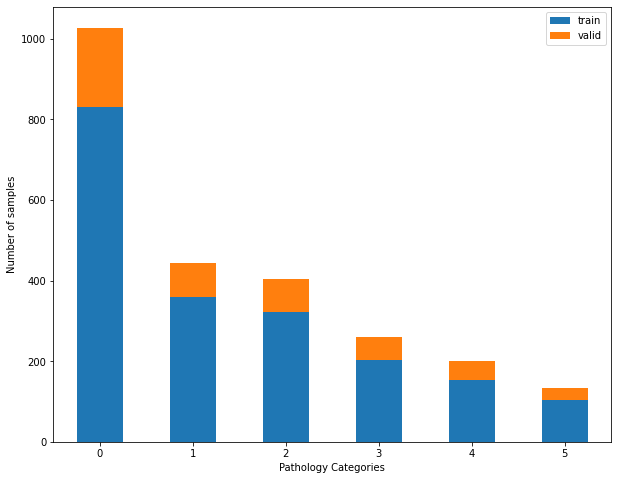

In [12]:
cnt_train = df_6_ite_1[df_6_ite_1['is_valid']==False]['target'].value_counts()
cnt_valid = df_6_ite_1[df_6_ite_1['is_valid']==True]['target'].value_counts()
plt.figure()
df_cnt = pd.DataFrame({'train': cnt_train,'valid': cnt_valid})
chart = df_cnt.plot.bar(rot=0, figsize=(10, 8), fontsize=10, stacked=True).get_figure()
plt.xlabel("Pathology Categories")
plt.ylabel("Number of samples")

chart.savefig('../resource/visualize/visual_sup_6_patho_ite_1.png')

In [69]:
# cnt_train = df_train['Groupby_Categories']
# cnt_train_labeled, cnt_train_unlabeled = train_test_split(cnt_train, test_size = 0.9, random_state = 0)
# cnt_train_labeled, cnt_train_unlabeled = cnt_train_labeled.value_counts(), cnt_train_unlabeled.value_counts()
# cnt_valid = df_valid['Groupby_Categories'].value_counts()

# df_cnt = pd.DataFrame({'train_labeled': cnt_train_labeled, 
                       
#                        'train_unlabeled': cnt_train_unlabeled,
#                        'valid': cnt_valid,
#                        })
# chart_semi = df_cnt.plot.bar(rot=0, 
#                         figsize=(10, 8), 
#                         fontsize=15,
#                         color={"train_labeled": "#1f76b5", "train_unlabeled": "green", "valid":"#fe7e0e"},
#                         stacked=True).get_figure()
# chart_semi.savefig('../resource/visualize/visual_semi_1_9.png')

In [70]:
# cnt_train_labeled, cnt_train_unlabeled

In [71]:
# df_train['Groupby_Categories'].value_counts()
# fig_train.savefig('../resource/visualize/groupcat_train.png')

In [72]:
# df_valid['Groupby_Categories'].value_counts()
# fig_valid.savefig('../resource/visualize/groupcat_valid.png')

In [14]:
# fig.savefig('../resource/visualize/groupcat.png')

In [15]:
# df_full.to_csv('../resource/hyper_kvasir/full_labeled_group.csv', index=False, header=True)